In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Extract columns from dataframe
df_cur1 = pd.read_csv('20170601_EU.csv')
cur1_col1 = df_cur1.iloc[:, 0:1].values
#cur1_col2 = df_cur1.iloc[1]

df_cur2 = pd.read_csv('20170601_EC.csv')
cur2_col1 = df_cur2.iloc[:, 0:1].values
#cur2_col2 = df_cur2.iloc[1]

In [3]:
# Sample size parameter
samplesize = 5000

other_ratio, this_ratio, cur1_localmax, cur2_localmax, cur1_localmin, cur2_localmin = ([] for i in range(6))

for i in range(samplesize, len(cur1_col1)-1):
    # Get localmaxes and localmins respectively from extracted datasets
    cur1_localmax.insert(i-samplesize, float(max(cur1_col1[i-samplesize:i-1])))
    cur2_localmax.insert(i-samplesize, float(max(cur2_col1[i-samplesize:i-1])))
    cur1_localmin.insert(i-samplesize, float(min(cur1_col1[i-samplesize:i-1])))
    cur2_localmin.insert(i-samplesize, float(min(cur2_col1[i-samplesize:i-1])))
    
    # Array boundary precausions
    if i > 0:
        # Calculate ratios
        o_r = (cur2_col1[i] - cur2_localmin[i-samplesize-1])/(cur2_localmax[i-samplesize-1] - cur2_localmin[i-samplesize-1])
        t_r = (cur1_col1[i] - cur1_localmin[i-samplesize-1])/(cur1_localmax[i-samplesize-1] - cur1_localmin[i-samplesize-1])
        # Prevent o_r !E {[0,1]}
        if o_r > 1:
            other_ratio.insert(i-samplesize, 1)
        elif o_r < 0:
            other_ratio.insert(i-samplesize, 0)
        else:
            other_ratio.insert(i-samplesize, o_r)
            
        if t_r > 1:
            this_ratio.insert(i-samplesize, 1)
        elif t_r < 0:
            this_ratio.insert(i-samplesize, 0)
        else:
            this_ratio.insert(i-samplesize, t_r)

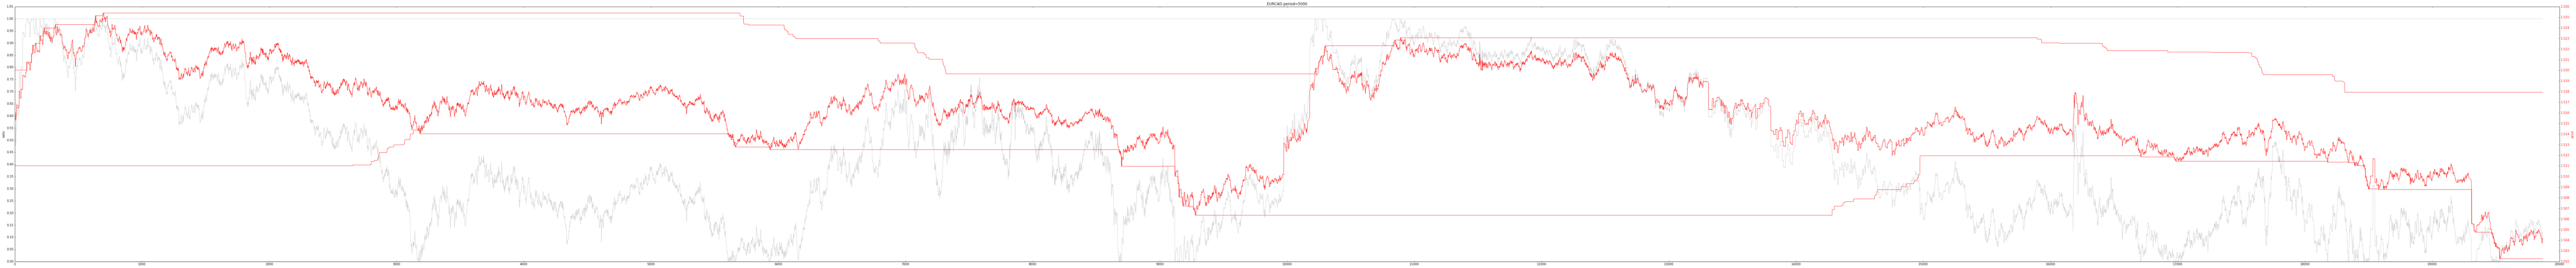

In [4]:
# Preparing to plot on multiple y-axes
fig = plt.figure(figsize=(150, 15))
ax1 = fig.add_subplot(111)

ax1.plot(other_ratio, '#cdcdcd')
ax1.plot([1]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.plot([0]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.set_ylabel('ratio')
ax1.locator_params(nbins=30)

# Add subplot with different axis range
ax2 = ax1.twinx()
ax2.plot(cur2_localmax, 'r', linewidth=1.0)
ax2.plot(cur2_localmin, 'r', linewidth=1.0)
ax2.plot(cur2_col1[samplesize:len(other_ratio)+samplesize], 'r', linewidth=1.0)
ax2.locator_params(nbins=30)
ax2.set_ylabel('price', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.title('EURCAD period=' + str(samplesize))
plt.xlabel('(ticks)')
#plt.show()
plt.savefig('EURCAD_coint.pdf')

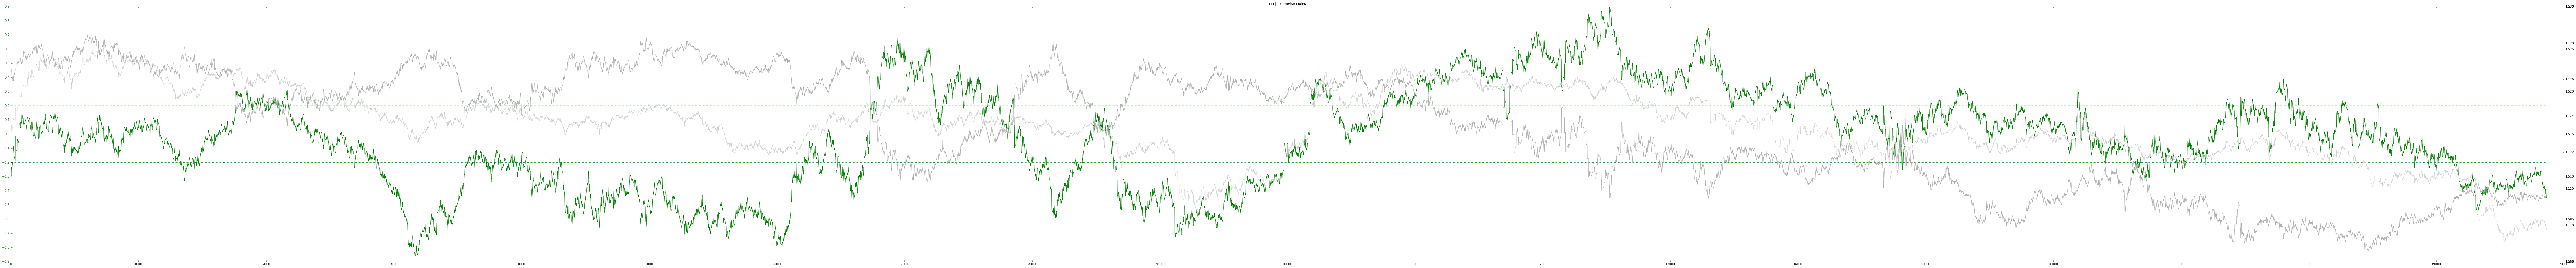

In [5]:
fig2 = plt.figure(figsize=(150, 15))
ax2_1 = fig2.add_subplot(111)
ax2_2 = fig2.add_subplot(111)

# Calculate ratio delta array
delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]

# Plot delta with thresholds
ax2_2.plot(delta, 'g')
ax2_2.plot([0.2]*len(other_ratio), 'g--')
ax2_2.plot([0]*len(other_ratio), 'g--')
ax2_2.plot([-0.2]*len(other_ratio), 'g--')

for tl in ax2_1.get_yticklabels():
    tl.set_color('g')
'''
ax2_1.plot(this_ratio, 'r')
ax2_1.plot(other_ratio, 'b')
'''
ax2_1.twinx().plot(cur2_col1[samplesize:len(other_ratio)+samplesize], '#cdcdcd', linewidth=1.0)
ax2_1.twinx().plot(cur1_col1[samplesize:len(other_ratio)+samplesize], '#adadad', linewidth=1.0)
ax2_1.locator_params(nbins=30)
plt.title('EU | EC Ratios Delta')
plt.savefig('ratios_coint.pdf')
#plt.show()

In [43]:
# Simple backtesting engine
#---

class order():
    def order_open(self):
        pass
    def order_close(self):
        pass
    
opened = False
open_rates = [0]*2
trade_1 = 0
trade_2 = 0
net_pips = [0]
np = 1 #(net pips iter)

wins = 0
losses = 0

# Target/Stop parameters
# > compute as fraction of volatility
target = 0.001
stop = 0.001

for x in range(len(other_ratio)):
    if opened == False and trade_1 == trade_2 == 0:
        if delta[x] >= 0.2:
            opened = True
            tradetype = 1
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            trade_1 = 1
            trade_2 = 1
            #open_rates = getOpenRates[cur1_col1[samplesize+x], cur2_col1[samplesize+x]]

        elif delta[x] <= -0.2:
            opened = True
            tradetype = 0
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            trade_1 = 1
            trade_2 = 1
            
    '''
    >
    RESTRUCTURE ENTIRE CLOSING SEQUENCE
    
    consider intrinsic pip value
    sort everything by symbol
    expand on class to simplify clause
    '''
    # if opened
    else:
        if tradetype == 1:
            # Winners
            if trade_1 == 1 and (delta[x] == 0 or cur1_col1[samplesize+x] <= open_rates[0] - target or cur2_col1[samplesize+x] >= open_rates[0] + target):
                # > Adjust pips by EC/EU worth
                net_pips.insert(np, net_pips[np-1] + abs(open_rates[0]-cur1_col1[samplesize+x])*10000)
                np += 1
                trade_1 = 0
                wins += 1
            # Losers
            # > Verify logic
            elif trade_2 == 1 and (delta[x] == 0 or cur1_col1[samplesize+x] <= open_rates[0] + stop or cur2_col1[samplesize+x] <= open_rates[0] - stop):
                # > Adjust pips by EC/EU worth
                net_pips.insert(np, net_pips[np-1] - abs(open_rates[1]+cur2_col1[samplesize+x])*10000)
                np += 1
                trade_2 = 0
                losses += 1
            opened = False
        else:
            # Winners
            if trade_1 == 1 and (delta[x] == 0 or cur1_col1[samplesize+x] >= open_rates[0] + target or cur2_col1[samplesize+x] <= open_rates[0] - target):
                # > Adjust pips by EC/EU worth
                net_pips.insert(np, net_pips[np-1] + abs(open_rates[0]-cur1_col1[samplesize+x])*10000)
                np += 1
                trade_1 = 0
                wins += 1
            # Losers
            # > Verify logic
            elif trade_2 == 1 and (delta[x] == 0 or cur1_col1[samplesize+x] >= open_rates[0] - stop or cur2_col1[samplesize+x] >= open_rates[0] + stop):
                # > Adjust pips by EC/EU worth
                net_pips.insert(np, net_pips[np-1] - abs(open_rates[1]-cur2_col1[samplesize+x])*10000)
                np += 1
                trade_2 = 0
                losses += 1
            opened = False
       

# Store rates in arrays
def getOpenRates(rate1, rate2):
    open_rates = [0]*2
    open_rates[0] = rate1
    open_rates[1] = rate2
    return open_rates

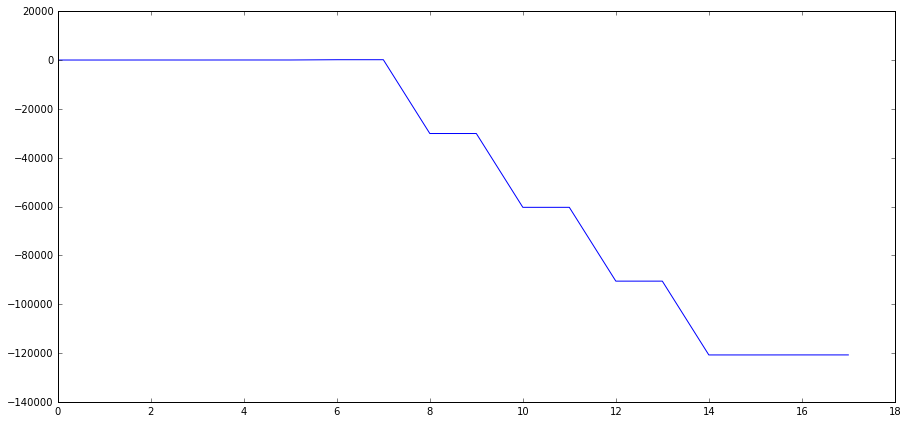

wins: 8
losses: 9


In [44]:
'''
for x in range(len(net_pips)):
    if net_pips[x] == 0:
        del net_pips[x]
'''
fig = plt.figure(figsize = (15, 7))
ax3 = fig.add_subplot(111)
ax3.plot(net_pips)
plt.show()

print('wins:', wins)
print('losses:', losses)

#plt.plot(net_pips)
#plt.show()